# Initialization

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

import numpy as np
import torch
import torch.nn as nn
import torchvision
from pkg_resources import packaging
import matplotlib.pyplot as plt
import clip
from PIL import Image
import os
from glob import glob
from tqdm import tqdm

In [ ]:
# load the CLIP model and freeze all its parameters

model, preprocess = clip.load("RN50x4")
model.eval()
model.trainable = False
m = model.requires_grad_(False)

100%|███████████████████████████████████████| 402M/402M [00:04<00:00, 86.4MiB/s]


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# Download some images from drive and classify them in folders

!wget https://docs.google.com/uc?id=1jP081zYPv1AKVwrOg2UZFlU_nPd8lLS5 -O /content/trump1.zip
!wget https://docs.google.com/uc?id=1yUDmA07-519KOpTEHbEebZR8SLrcVhKC -O /content/trump2.zip
!wget https://docs.google.com/uc?id=196fkPNzgoayxlTg06yEf43YO13QLO2YG -O /content/usa.zip
!wget https://docs.google.com/uc?id=1pbkUuPjVtAr6EKJaadBAqk6l6Y-xodZd -O /content/flags.zip
!wget https://docs.google.com/uc?id=1eZS_7seR9j7iSWrKINPfKI9fhKLElVpw -O /content/dogs.zip

!rm -r /content/trump1
!mkdir /content/trump1                              # unzip trump1.zip to new trump1 directory
!unzip /content/trump1.zip -d /content/trump1
trump_files1 = glob(os.path.join('/content/trump1', "**"))   # get the paths of all files in trump1 directory

!rm -r /content/trump2
!mkdir /content/trump2
!unzip /content/trump2.zip -d /content/trump2
trump_files2 = glob(os.path.join('/content/trump2', "**"))

!rm -r /content/usa
!mkdir /content/usa
!unzip /content/usa.zip -d /content/usa
usa_files = glob(os.path.join('/content/usa', "**"))

!rm -r /content/flags
!mkdir /content/flags
!unzip /content/flags.zip -d /content/flags
flags_files = glob(os.path.join('/content/flags', "**"))

!rm -r /content/dogs
!mkdir /content/dogs
!unzip /content/dogs.zip -d /content/dogs
dogs_files = glob(os.path.join('/content/dogs', "**"))

#!rm -r /content/myanimals
#!mkdir /content/myanimals
#!unzip /content/drive/MyDrive/myanimals.zip -d /content/myanimals
#myanimals_files = glob(os.path.join('/content/myanimals/myanimals', "**"))

--2024-03-04 14:31:04--  https://docs.google.com/uc?id=1jP081zYPv1AKVwrOg2UZFlU_nPd8lLS5
Resolving docs.google.com (docs.google.com)... 142.251.2.101, 142.251.2.100, 142.251.2.139, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1jP081zYPv1AKVwrOg2UZFlU_nPd8lLS5 [following]
--2024-03-04 14:31:04--  https://drive.usercontent.google.com/download?id=1jP081zYPv1AKVwrOg2UZFlU_nPd8lLS5
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.101.132, 2607:f8b0:4023:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.101.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 475559 (464K) [application/octet-stream]
Saving to: ‘/content/trump1.zip’

/content/trump1.zip 100%[===================>] 464.41K  --.-KB/s    in 0.1s    

2024-03-04 14:31:06 (3.79 MB/s) - 

# Modality Gap

In [ ]:
!pip install umap-learn
import umap

In [ ]:
import skimage  # We will use these images
os.listdir(skimage.data_dir)

['motorcycle_right.png',
 'lbpcascade_frontalface_opencv.xml',
 'coffee.png',
 'chessboard_GRAY.png',
 'phantom.png',
 'rocket.jpg',
 'gravel.png',
 'coins.png',
 'page.png',
 'color.png',
 'clock_motion.png',
 'brick.png',
 'horse.png',
 'README.txt',
 'retina.jpg',
 'camera.png',
 'chelsea.png',
 'astronaut.png',
 'microaneurysms.png',
 'grass.png',
 'motorcycle_left.png',
 'ihc.png',
 'cell.png',
 'logo.png',
 'chessboard_RGB.png',
 'lfw_subset.npy',
 'motorcycle_disp.npz',
 'text.png',
 'hubble_deep_field.jpg',
 'moon.png']

In [ ]:
images = []
legends = []
for filename in os.listdir(skimage.data_dir):           # Use only jpg and png images, create texts: This is a + image caption for each image
  if filename.endswith(".png") or filename.endswith(".jpg"):
    images.append(preprocess(Image.open(os.path.join(skimage.data_dir, filename))))
    name = os.path.splitext(filename)[0]
    legends.append("This is a" + name)

image_input = torch.tensor(np.stack(images)).cuda()           # Preprocess text and images, get model outputs and normalize
text_tokens = clip.tokenize(legends).cuda()

image_features = model.encode_image(image_input).cpu()
text_features = model.encode_text(text_tokens).cpu()

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

In [ ]:
features = torch.cat([image_features, text_features]) # concantenate the features in one tensor

In [ ]:
reducer = umap.UMAP()    # reduce dimensions to 2 using UMAP
embedding = reducer.fit_transform(features)

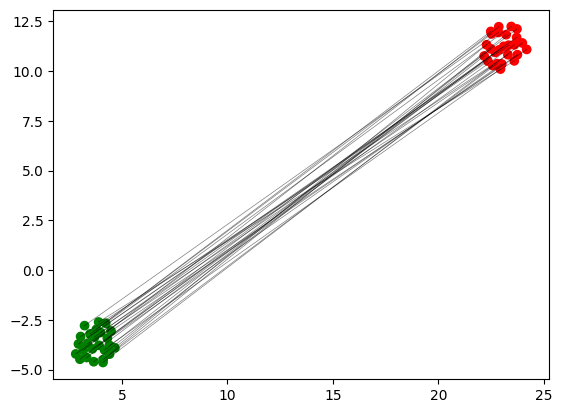

In [ ]:
# Plot the text embeddings with green and the image embeddings with red, a line connects each pair of embeddings

colors = ["r", "g"]
count = len(images)
for i in range(count):
  x_points = [embedding[i][0], embedding[count + i][0]]
  y_points = [embedding[i][1], embedding[count + i][1]]
  plt.plot(x_points, y_points, color = 'black', linewidth = .5, alpha = .5)
  plt.scatter(x_points, y_points, color = colors)
plt.show()